In [1]:
%matplotlib widget
import os
import sys
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import math

# Helper function for 'axis equal' in matplotlib's 3d view 
def set_3d_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)
    plot_radius = 0.5*max([x_range, y_range, z_range])
    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])    

# Content

- General introduction (problem definiations, loss function, least-squares and connection to statistics).
- Non-linear iterative optimization: Newton's method, Gauss-Newton, Levenberg-Marquardt method
- Exact Jacobians: symbolic computation vs. automatic differentation
- Rotation representations, constraints and optimization on manifolds
- Exploiting sparsity for faster convergence


# Introduction

Let's start with motivation. Let's look at the following linear system:

$ Ax = b $

where $A$ is the so called coefficient matrix, $x$ is the vector of unknowns and $b$ is the right hand side vector.

In practice there is no $x$ vector that would satisfy the above equation: $Ax \neq b$. This typically happens due to the system is overdetermined, such as in case of leveling network adjustment, or in regression problems. The situation is not lost to find an appropriate $x$ value: we need to impose additional condition to find a solution. First we define the the vector of residuals:

$ r(x) = Ax - b $,

and then,

$ \min_{x} l(r(x))$

is an optimization problem, where $l \in \mathbb{R}^n \rightarrow \mathbb{R}$ is called the loss function. The choice of loss function might depend on the underlying stochastic properties of the problem:

- $l(x) = x^Tx$, is the widely used least-squares estimation. This estimation is so called best linear unbiased estimator (BLUE) if the $r$ vector as stochastic variable follows normal distribution
- $l(x) = \sum_i ||x_i||$ L1 norm
- Huber loss, which is used in the presence of gross errors.

However our model is typically non-linear, and thus 

$r(x) = F(x) - b $.

Therefore the above presented optimization problem should be solved with some non-linear optimization technique.


# Problem definition

Applications:
- Iterative closest point algorithm for point cloud registration
- Robot navigation
- Optimal transformation between two trajectories
- [Comparing moluecular structures](https://cnx.org/contents/HV-RsdwL@23/Molecular-Distance-Measures)

We wish to solve the following non-linear least squares problem:
$$ 
\min_{R,\mathbf{t}} \sum_{i=1}^{N} \lVert(R\mathbf{p}_i + \mathbf{t}) - \mathbf{q}_i\lVert_2,
$$
where $R \in SO(3)$ is the rotation matrix, $\mathbf{t}\in \mathbb{R}^3$ is the translation vector and $\mathbf{p}_i, \mathbf{q}_i \in \mathbb{R}^3$ are the model and target points, respectively. With $\mathbf{r}(R, \mathbf{t}) = (R\mathbf{p}_i + \mathbf{t}) - \mathbf{q}_i$ residual vector function, the problem can be written as:
$$ 
\min_{R,\mathbf{t}} \sum_{i=1}^{N} \mathbf{r}(R,\mathbf{t})^2,
$$
or in vector form:
$$ 
\min_{R,\mathbf{t}} \mathbf{r}^\mathsf{T}(R,\mathbf{t}) \mathbf{r}(R,\mathbf{t}).
$$


To work with some data, we generate random points:

In [2]:
np.random.seed(10)
pts_model = np.random.rand(10, 3) + np.array([1, 2, 3]) # so the point are not around the origin

Then we need the ground truth rotation and translation values. I parametrize the rotation vector via Euler angles: $R(\gamma, \beta, \alpha)$, where $\gamma$ is the yaw, $\beta$ is the pitch and $\alpha$ is the roll angle. 

In [3]:
ypr_gt = [45/180.0*math.pi, -15/180.0*math.pi, 20/180.0*math.pi]
t_gt = [1, -2, 3]
x_gt = np.append(ypr_gt, t_gt)

The Euler angles are intrepreted as intrinsic rotations around the Z, Y and final the X axis.

In [4]:
R_gt = Rotation.from_euler('ZYX', ypr_gt, degrees=False).as_matrix()

 Note that this is the same rotation as defining the extrinsic rotation in X, Y, Z axis order, but roll, pitch, yaw angle order.

In [5]:
R_int = Rotation.from_euler('ZYX', ypr_gt, degrees=False).as_matrix()
R_ext = Rotation.from_euler('xyz', [ypr_gt[2], ypr_gt[1], ypr_gt[0]], degrees=False).as_matrix()
np.linalg.norm(R_ext - R_int)

8.326672684688674e-17

Finally we apply the rotation on our synthetic data:

In [6]:
pts_target = (R_gt @ pts_model.T).T + t_gt

The random model points and the transformet target points look like this in 2D:

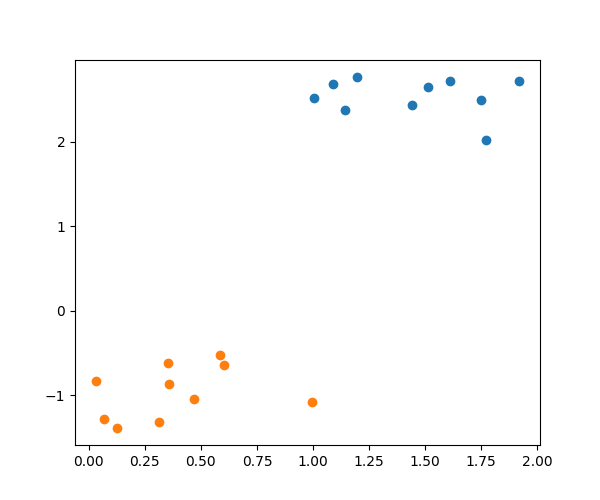

In [7]:
plt.figure(figsize=(6,5))
plt.scatter(pts_model[:, 0], pts_model[:, 1])
plt.scatter(pts_target[:, 0], pts_target[:, 1])

... and in 3D:

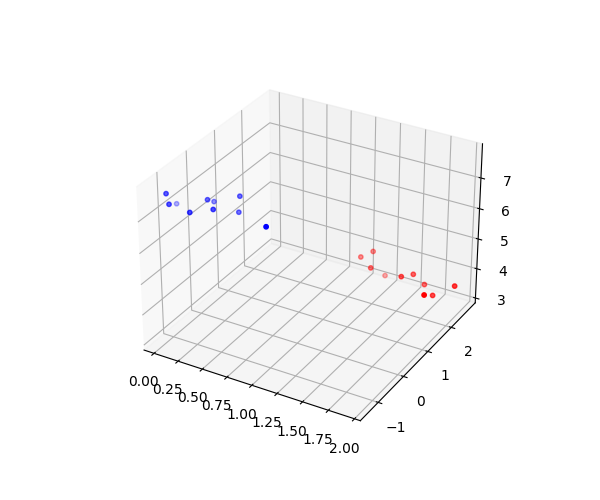

In [8]:
def viz_solution(pts_model, pts_target, pts_model_hat=None):
    plt.figure(figsize=(6,5))
    ax = plt.axes(projection='3d')
    ax.scatter3D(pts_model[:,0], pts_model[:,1], pts_model[:,2], c='r', s=10)
    ax.scatter3D(pts_target[:,0], pts_target[:,1], pts_target[:,2], c='b', s=10)
    if pts_model_hat is not None:
        ax.scatter3D(pts_model_hat[:,0], pts_model_hat[:,1], pts_model_hat[:,2], c='g', s=10)

viz_solution(pts_model, pts_target)

# Solution #1: Singular value decomposition ([Kabsch-Umeyama algorithm](https://en.wikipedia.org/wiki/Kabsch_algorithm))

In his 1978 paper, titled ["A discussion of the solution for the best rotation to relate two sets of vectors"](https://onlinelibrary.wiley.com/doi/abs/10.1107/S0567739478001680), Wolfgang Kabsch gave a closed form solution for the least squares estimate of the rotation, i.e. when $\mathbf{t} = \mathbf{0}$.  However obtaining the translation is somewhat trivial, Umeyama completes Kabsch algorithm in his 1991 paper titled ["Least-squares estimation of transformation parameters between two point patterns"](https://web.stanford.edu/class/cs273/refs/umeyama.pdf). For a more recent derivation, as it appears in modern computer vision courses, see the [lecture notes from ETH Zurich](https://igl.ethz.ch/projects/ARAP/svd_rot.pdf). Note that this is the standard way to solve the problem of finding the optimial transform between two sets of points in least squares sense.

SVD decomposition is the standard and most efficient way to find the rigid body transformation between two point sets.

First we need to compute the center of gravity (or the means) of the two point sets:
$$
\bar{\mathbf{p}} = \frac{\sum_{i=1}^N \mathbf{p}_i}{N}, 
$$
$$
\bar{\mathbf{q}} = \frac{\sum_{i=1}^N \mathbf{q}_i}{N},
$$
and then, move the point sets to their respective center of gravities:
$$
\tilde{\mathbf{p}} = \mathbf{p} - \bar{\mathbf{p}},  
$$
$$
\tilde{\mathbf{q}} = \mathbf{q} - \bar{\mathbf{q}} .
$$

In [9]:
cog_model = np.mean(pts_model, axis=0)
cog_target = np.mean(pts_target, axis=0)

pts_model_cog = pts_model - cog_model
pts_target_cog = pts_target - cog_target

In [10]:
C = pts_model_cog.T @ pts_target_cog

In [11]:
# %% SVD decomposition
[U, S, V] = np.linalg.svd(C)
V = V.T
C_chk = U @ np.diag(S) @ V.T
print('Check decomposition ( =0): ', np.linalg.norm(C_chk - C))

Check decomposition ( =0):  8.587626973376621e-16


In [12]:
R_svd = V @ U.T
t_svd = cog_target - R_svd @ cog_model

print('Check R ( =0): ', np.linalg.norm(R_svd - R_gt))
print('Check t ( =0):', np.linalg.norm(t_svd - t_gt))

Check R ( =0):  1.0153572273985581e-15
Check t ( =0): 3.1165445441279525e-15


In [13]:
pts_model_hat = (R_svd @ pts_model.T).T + t_svd

In [14]:
res_svd = np.linalg.norm(pts_model_hat - pts_target, axis=1)
print('Check transformation ( =0)', np.linalg.norm(res_svd))

Check transformation ( =0) 1.5895974606912448e-15


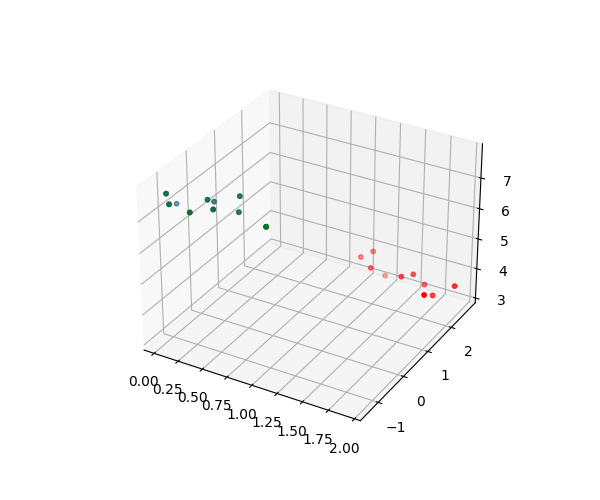

In [15]:
viz_solution(pts_model, pts_target, pts_model_hat)

Computation time of SVD can be found here: https://www.cs.utexas.edu/users/inderjit/public_papers/HLA_SVD.pdf

# Solution #2: with solving matrix inverse

In [16]:
from scipy.linalg import sqrtm

We can also obtain the solution using following [formula](https://en.wikipedia.org/wiki/Kabsch_algorithm):
$$
R = (C^\mathsf{T}C)^{1/2}C^{-1}
$$

In [17]:
R_minv = sqrtm(C.transpose() @ C) @ np.linalg.inv(C)
print(np.linalg.norm(R_gt - R_minv))

2.5931789359437717e-15


# Solution #3: using derivative-free *scipy* optimizer

In [18]:
from scipy.optimize import minimize

In [19]:
R_x =  lambda x0: Rotation.from_euler('ZYX', x0[:3], degrees=False).as_matrix()
r_x = lambda x0: ((R_x(x0) @ pts_model.T).T + np.array([x0[3:6]]) - pts_target).ravel()
print('Check residual function ( =0): ', np.linalg.norm(r_x(x_gt)))

Check residual function ( =0):  0.0


We will use the derivative free simplex method.

In [20]:
x0 = np.array([45.0-15.0, -15.0+25.0, 20.0+25.0, 1.0+1.5, -2.0+1.8, 3.0-1.2]) # converges to the solution in 914 iterations
x0[:3] *= 1.0/180.0*math.pi
#x0 = np.array([0, 0, 0, 0, 0, 0]) # converges to local minumum
    
res = minimize(lambda x: np.linalg.norm(r_x(x)), x0, method='nelder-mead',
               options={'xatol': 1e-6, 'disp': True, 'maxiter': 2000})

print('Check solution ( =0): ', np.linalg.norm(res.x - x_gt))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 914
         Function evaluations: 1434
Check solution ( =0):  3.1873147736009076e-07


As we can see this method is relatively sensitive to the choosen initial guess.

However, we can find another derivative-free algorithm that provides the solution even with extreme initial guess. See the example with [BFGS](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#broyden-fletcher-goldfarb-shanno-algorithm-method-bfgs).

In [21]:
x0 = np.array([0, 0, 0, 0, 0, 0]) # converges to the solution in 49 iterations
res = minimize(lambda x: np.linalg.norm(r_x(x)), x0, method='BFGS',
               options={'disp': True, 'maxiter': 2000})

print('Check solution ( =0): ', np.linalg.norm(res.x - x_gt))

         Current function value: 0.000001
         Iterations: 49
         Function evaluations: 887
         Gradient evaluations: 125
Check solution ( =0):  1.6784754678364918e-06


# Solution #4: Newton's method & algebraic gradient and Hessian

Non linear iterative optimizors can be described with the following general form:

$ x_{k+1} = x_{k} + \Delta x $

where $k$ is the iteration number, $ \Delta x $ is called the update step. $x_0$ is the initial guess and needs to be provided. The iteration is terminated if some stopping criteria is reached, for instance:

- the update step reaches a threshold, e.g. $ ||\Delta x|| < \epsilon $; this is often refered as step tolerance, and

- the difference of the function values at the consecutive unknowns meets a predifined value, e.g. $ ||f(x_k) - f(x_{k-1})|| < \epsilon $; this is often refered as function tolerance.

Different optimizors define the update step differently. For instance the gradient descent mehtod uses the gradient of the function and a predefinied or heuristically updated step size:

$ \Delta x_{k+1} = \alpha_k \nabla f(x_k) $

Gradient descent exhibits robust convergence properties (can find the solution) but slow convergence rate in general (finding the solution can take many iterations).

Newton's method is a general optimization technique typically shows faster convergence rate than gradient descent. The Newton's update step, also called newton step is as follows:

$ \Delta x_{k+1} = H_{f(x_k)}^{-1}(x_k) \nabla f(x_k) $

The connetion between the descent and Newton's method is clear: $ \alpha_k = H_{f(x_k)}^{-1}(x_k) $.

The Hessian can be interpreted many ways:

- Second order approximator
- Steepest decent direction in Hessian norm

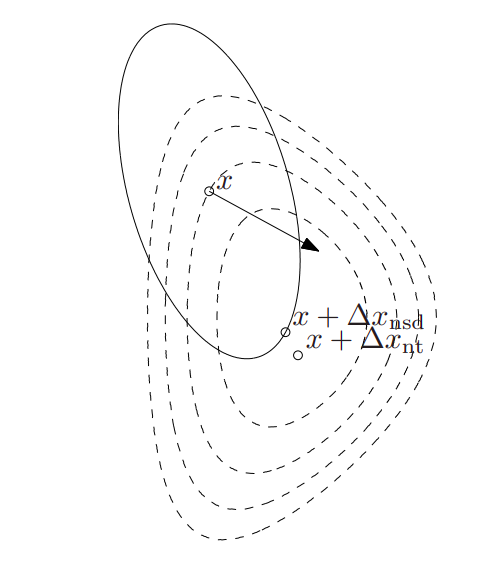
Source: https://stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=498&zoom=100,214,410

In the 2000s, a special problem class, the so called convex functions and their optimization become the interst of many research. The reason that researchers found many ways to convert problems to convex problems. It's relatively easy to see that Newton's method can provide globally optimal solution for complex problems. 

In [22]:
import sympy as sym
from math import cos, sin, pi

In order to improve on the convergence rate and hopefully improve on the sensitivity of the initial guess, let's try to use analytical derivatives.

In [23]:
o, p, k, x, y, z = sym.symbols('o p k x y z')

In [24]:
def Rx_s(theta):
  return sym.Matrix([[ 1, 0           , 0           ],
                   [ 0, sym.cos(theta),-sym.sin(theta)],
                   [ 0, sym.sin(theta), sym.cos(theta)]])
  
def Ry_s(theta):
  return sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-sym.sin(theta), 0, sym.cos(theta)]])
  
def Rz_s(theta):
  return sym.Matrix([[sym.cos(theta), -sym.sin(theta), 0 ],
                   [ sym.sin(theta), sym.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

ypr2rot_sym = lambda k, p, o: Rz_s(k) @ Ry_s(p) @ Rx_s(o)
#print('Check rotation composition ( =0)', np.linalg.norm(R_fn(ypr_gt[0], ypr_gt[1], ypr_gt[2]) - R_gt))

In [25]:
R_sym = ypr2rot_sym(k, p, o)
R_sym_sub = R_sym.subs({k: float(ypr_gt[0]), p: float(ypr_gt[1]), o: float(ypr_gt[2])})
R_sym_sub_np = np.array(R_sym_sub.tolist()).astype('float')
print('Check rotation composition ( =0): ', np.linalg.norm(R_sym_sub_np - R_gt))

Check rotation composition ( =0):  5.028663855320258e-16


Define cost function:

In [26]:
dt_sym = np.tile(np.array([x, y, z]), (pts_model.shape[0], 1))
res_sym_vec = (R_sym @ pts_model.T).T + dt_sym - pts_target
res_sym_vec = res_sym_vec.reshape(pts_model.shape[0]*3, 1) # reshape it from (N x 3) -> (M x 1)
cost_fn_sym = res_sym_vec.T @ res_sym_vec

print('Number of chars of cost function :', len(str(cost_fn_sym)), '  ', len(str(cost_fn_sym))/1000, 'kB')

Number of chars of cost function : 5651    5.651 kB


In [27]:
cost_fn_sym = sym.simplify(cost_fn_sym) # this might take a bit of time
print('Number of chars of cost function :', len(str(cost_fn_sym)), '  ', len(str(cost_fn_sym))/1000, 'kB')

Number of chars of cost function : 1053    1.053 kB


Define & lambdify gradient function: 

In [28]:
g = sym.Matrix([cost_fn_sym.diff(var) for var in [k, p, o, x, y, z]])
# g = g.applyfunc(sym.simplify) # does not change anything

g_x_sym = lambda x0: g.subs({k: float(x0[0]), p: float(x0[1]), o: float(x0[2]), 
                             x: float(x0[3]), y: float(x0[4]), z: float(x0[5])})
g_x = lambda x0: np.array(g_x_sym(x0).tolist()).astype('float')
print('Check gradient (= 0): ', np.linalg.norm(g_x(x_gt)))
print('Number of chars of gradient function :', len(str(g)), '  ', len(str(g))/1000, 'kB')

Check gradient (= 0):  8.35454444562689e-14
Number of chars of gradient function : 2675    2.675 kB


Define & lambdify Hessian matrix: 

In [29]:
H = sym.hessian(cost_fn_sym, [k, p, o, x, y, z])
#H = H.applyfunc(sym.simplify) # only small imporvement: 7280 vs. 7338 chars

H_x_sym = lambda x0: H.subs({k: float(x0[0]), p: float(x0[1]), o: float(x0[2]), 
                             x: float(x0[3]), y: float(x0[4]), z: float(x0[5])})
H_x = lambda x0: np.array(H_x_sym(x0).tolist()).astype('float')

print('Shape of Hessian (= (6,6)) : ', H_x(x_gt).shape)
print('Min value of Eigenvalues (> 0): ', np.min(np.linalg.eigvals(H_x(x_gt))))
print('Number of chars of Hessian function :', len(str(H)), '  ', len(str(H))/1000, 'kB')

Shape of Hessian (= (6,6)) :  (6, 6)
Min value of Eigenvalues (> 0):  0.07609313347492395
Number of chars of Hessian function : 7338    7.338 kB


Solve the problem with Newton's method. The method should exhibit quadratic convergence if x0 is "good enough".

In [30]:
def optimizer_framework(step_function, x0, x_gt, iter_callback=None):
    print('Iteration # {:6s} {:18s} {:15s} {:20s}'.format('', 'delta gt', 'dx', 'dr'))
    print('----------------------------------------------------------------')
    def print_iter(iter_num, chk, dx, dr):
        print('Iteration #{:d} {:15.8f} {:15.8f} {:15.8f}'.format(iter_num, chk, dx, dr))

    dx = np.inf
    iter_num = 0

    print_iter(iter_num, np.linalg.norm(x0 - x_gt), np.nan, np.linalg.norm(g_x(x0)))
    while np.linalg.norm(dx) > 1e-6 and iter_num < 100:
        iter_num += 1
        dx = step_function(x0)
        x0 = x0 - dx

        if iter_callback is not None:
            iter_callback(x0)
        print_iter(iter_num, np.linalg.norm(x0 - x_gt), np.linalg.norm(dx), np.linalg.norm(r_x(x0)))
        
    print('Check solution ( =0): ', np.linalg.norm(x0 - x_gt))

In [31]:
x0 = np.array([45.0-15.0, -15.0+25.0, 20.0-25.0, 1.0+10.5, -2.0-10.8, 3.0-1.2]) # converging to the solution in 8 iterations
#x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # converging to a local minimum in 20 iteration
x0[:3] *= 1.0/180.0*pi

def newton_step(x):
    dx = np.linalg.inv(H_x(x)) @ g_x(x)
    return dx.reshape(-1)

optimizer_framework(newton_step, x0, x_gt)

Iteration #        delta gt           dx              dr                  
----------------------------------------------------------------
Iteration #0     15.12545241             nan   1259.95476705
Iteration #1      3.01958731     14.40831646      0.75899083
Iteration #2      2.25179108      4.86883458      8.30270134
Iteration #3      1.79218099      2.59172528      0.54922379
Iteration #4      0.47753007      1.74003506      1.50710882
Iteration #5      0.06017238      0.47710095      0.01266341
Iteration #6      0.00039927      0.06013586      0.00126521
Iteration #7      0.00000020      0.00039930      0.00000004
Iteration #8      0.00000000      0.00000020      0.00000000
Check solution ( =0):  7.808759780034745e-14


It seems this solution is also sensitive for the initial guess.

In [32]:
x0 = np.array([45.0-15.0, -15.0+25.0, 20.0-25.0, 1.0+10.5, -2.0-10.8, 3.0-1.2]) # converging to the solution in 8 iterations
x0[:3] *= 1.0/180.0*pi

cost_per_iter = []
def iter_callback(xk):
    dx_gt = np.linalg.norm(xk - x_gt)
    cost_per_iter.append(dx_gt)
    
def newton_step(x):
    dx = np.linalg.inv(H_x(x)) @ g_x(x)
    return dx.reshape(-1)

optimizer_framework(newton_step, x0, x_gt, iter_callback=iter_callback)

Iteration #        delta gt           dx              dr                  
----------------------------------------------------------------
Iteration #0     15.12545241             nan   1259.95476705
Iteration #1      3.01958731     14.40831646      0.75899083
Iteration #2      2.25179108      4.86883458      8.30270134
Iteration #3      1.79218099      2.59172528      0.54922379
Iteration #4      0.47753007      1.74003506      1.50710882
Iteration #5      0.06017238      0.47710095      0.01266341
Iteration #6      0.00039927      0.06013586      0.00126521
Iteration #7      0.00000020      0.00039930      0.00000004
Iteration #8      0.00000000      0.00000020      0.00000000
Check solution ( =0):  7.808759780034745e-14


Text(0.5, 1.0, "Convergence of Newton's method")

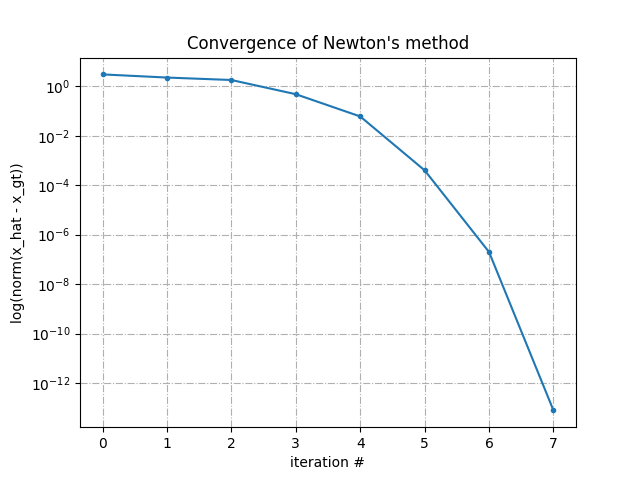

In [33]:
plt.figure()
plt.plot(range(len(cost_per_iter)), cost_per_iter, '.-')
plt.yscale('log')
plt.grid(True,which="both", linestyle='-.')
plt.ylabel('log(norm(x_hat - x_gt))')
plt.xlabel('iteration #')
plt.title("Convergence of Newton's method")

# Solution #5: Newton's method with *scipy* optimizer

In [34]:
from scipy.optimize import minimize

For better convergence properties, we can do line search with the Hessian. In the next we will use [built-in](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#newton-conjugate-gradient-algorithm-method-newton-cg) function that utilizes this technique. 

In [35]:
cost_per_iter = []
def iter_callback(xk):
    dx_gt = np.linalg.norm(xk - x_gt)
    cost_per_iter.append(dx_gt)
    print('Norm from GT: ', dx_gt)

x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # converging to the solution in 37 iterations
res = minimize(lambda x: np.linalg.norm(r_x(x)), x0, method='Newton-CG',
               jac=lambda x: g_x(x).reshape(-1),  hess=H_x,
               options={'xtol': 1e-6, 'disp': True, 'maxiter': 50}, callback=iter_callback)

Norm from GT:  3.7041334871323515
Norm from GT:  3.62944233756627
Norm from GT:  3.226214699361739
Norm from GT:  2.950638441802581
Norm from GT:  2.7276973985275763
Norm from GT:  2.5158539381998377
Norm from GT:  2.276835351748999
Norm from GT:  2.19763874122218
Norm from GT:  2.164089650025141
Norm from GT:  2.087460697274565
Norm from GT:  2.0412219657155033
Norm from GT:  2.0052894556731995
Norm from GT:  1.9697939285204098
Norm from GT:  1.9052790074311088
Norm from GT:  1.868769120081035
Norm from GT:  1.8089542337670592
Norm from GT:  1.8085551304490441
Norm from GT:  1.3103473838635593
Norm from GT:  1.3098042968294696
Norm from GT:  1.303384474040952
Norm from GT:  1.0836778423909463
Norm from GT:  1.0764688758789729
Norm from GT:  0.6282515191734298
Norm from GT:  0.6279927998000695
Norm from GT:  0.6237173997739611
Norm from GT:  0.3614343944950499
Norm from GT:  0.36132852693696377
Norm from GT:  0.3593894470815389
Norm from GT:  0.11828585335615903
Norm from GT:  0.118238

Text(0.5, 1.0, 'Convergence of Newton-CG method')

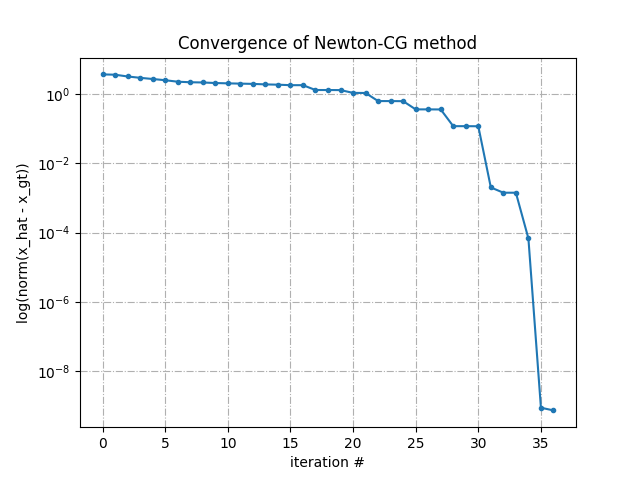

In [36]:
plt.figure()
plt.plot(range(len(cost_per_iter)), cost_per_iter, '.-')
plt.yscale('log')
plt.grid(True,which="both", linestyle='-.')
plt.ylabel('log(norm(x_hat - x_gt))')
plt.xlabel('iteration #')
plt.title("Convergence of Newton-CG method")

# Solution #6: Gauss-Newton method with algebraic Jacobian

We should take advantage of the fact that the problem is least squares. This will allow us to use more stable algorithms with faster convergence rate and with less sensitivity to the initial guess.

If we apply the following approximation, see [details](https://math.stackexchange.com/questions/1105214/difference-between-newtons-method-and-gauss-newton-method):

$ H(x) \approx J^T(x) J(x),$

$ \nabla f(x) = J^T(x)r(x) $ 

Then we arrive to the Gauss-Newton method:

$ \Delta x_{k+1} = (J_{f}^T(x_k) J_{f}(x_k))^{-1} J_{f}^T(x_k) r(x_k) $


Remarks:
- Gauss-Newton was almost always used before computers due to its relative simplicity.
- Gauss-Newton is a linear approximation vs. Newton's method is second order. Gauss-Newton does not need Hessian.
- Problem definiation for Gauss-Newton is a vector-vector function.
- Problem definiatioin for Newton'S method is scalar-vector function.
- Gauss-Newton assumes LS, and this, optimal soltuion requires that the residual vector as stochastic variable follow normal distribution.
- For the Newton's method, we "can choose" the loss function and hence can use different norms based on stochastic properties.

Create the Jacobian matrix for the least squares problem:

In [37]:
J = res_sym_vec.jacobian([k, p, o, x, y, z])
J_x_sym = lambda x0: J.subs({k: float(x0[0]), p: float(x0[1]), o: float(x0[2]), 
                             x: float(x0[3]), y: float(x0[4]), z: float(x0[5])})
J_x = lambda x0: np.array(J_x_sym(x0).tolist()).astype('float')
N = J_x(x0).T @ J_x(x0)


print('Shape of Jacobian: ', J.shape)
print('Shape of N: ', N.shape)
print('Number of chars of Jacobian function :', len(str(J)), '  ', len(str(J))/1000, 'kB')

Shape of Jacobian:  (30, 6)
Shape of N:  (6, 6)
Number of chars of Jacobian function : 10622    10.622 kB


... and the iterations looks more stable:

In [38]:
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # converging to the solution in 5 iterations

def gauss_newton_full_step(x):
    dr = r_x(x)
    dx =  np.linalg.inv(J_x(x).T @ J_x(x)) @ J_x(x).T @ dr
    return dx

optimizer_framework(gauss_newton_full_step, x0, x_gt)

Iteration #        delta gt           dx              dr                  
----------------------------------------------------------------
Iteration #0      3.84801717             nan    497.62780943
Iteration #1      1.51626838      4.81285259      3.25424394
Iteration #2      0.08253915      1.48703868      0.26340997
Iteration #3      0.00005337      0.08252769      0.00020193
Iteration #4      0.00000000      0.00005337      0.00000000
Iteration #5      0.00000000      0.00000000      0.00000000
Check solution ( =0):  4.641741426862217e-15


Surpresingly, almost quadratic convergence from the beginning with an initial guess far from the solution. However the above approach results in long Jacobian code. Instead we can compute the symbolic Jacobian for each point separatetly.

In [39]:
m_x, m_y, m_z = sym.symbols('m_x m_y m_z')
t_x, t_y, t_z = sym.symbols('t_x t_y t_z')

m_xyz = np.array([m_x, m_y, m_z])
t_xyz = np.array([t_x, t_y, t_z])

dt_sym_row = np.array([x, y, z])
eq_sym = (R_sym @ m_xyz).T + dt_sym_row - t_xyz

print('Shape of a single point pair equation: (= (3,))', eq_sym.shape)

Shape of a single point pair equation: (= (3,)) (3,)


In [40]:
J_point_tx = sym.Matrix([eq_sym[0].diff(x) for x in [k, p, o, x, y, z]]).T
J_point_ty = sym.Matrix([eq_sym[1].diff(x) for x in [k, p, o, x, y, z]]).T
J_point_tz = sym.Matrix([eq_sym[2].diff(x) for x in [k, p, o, x, y, z]]).T
J_point = sym.Matrix([J_point_tx, J_point_ty, J_point_tz])

print('Number of chars of Jacobian function :', len(str(J_point)), '  ', len(str(J_point))/1000, 'kB')

Number of chars of Jacobian function : 685    0.685 kB


In [41]:
J_point_sym = lambda x0, m_pt, t_pt: J_point.subs({k: float(x0[0]), p: float(x0[1]), o: float(x0[2]), 
                                                   x: float(x0[3]), y: float(x0[4]), z: float(x0[5]),
                                                m_x: float(m_pt[0]), m_y: float(m_pt[1]), m_z: float(m_pt[2]),
                                                t_x: float(t_pt[0]), t_y: float(t_pt[1]), t_z: float(t_pt[2])})

J_point_x = lambda x0, m_pt, t_pt: np.array(J_point_sym(x0, m_pt, t_pt).tolist()).astype('float')

In [42]:
def build_J(x):
    J_x = np.zeros((pts_model.shape[0]*3, 6))
    for pt_k in range(pts_model.shape[0]):
        J_x[(pt_k*3):(pt_k*3+3)] = J_point_x(x, pts_model[pt_k, :], pts_target[pt_k, :])
    return J_x

print('Check Jacobian composition ( =0): ', np.linalg.norm(build_J(x_gt) - J_x(x_gt)))

Check Jacobian composition ( =0):  0.0


In [43]:
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # converging to the solution in 5 iterations

def gauss_newton_step(x):
    dr = r_x(x)
    dx = np.linalg.inv(build_J(x).T @ build_J(x)) @ build_J(x).T @ dr
    return dx
    
optimizer_framework(gauss_newton_step, x0, x_gt)

Iteration #        delta gt           dx              dr                  
----------------------------------------------------------------
Iteration #0      3.84801717             nan    497.62780943
Iteration #1      1.51626838      4.81285259      3.25424394
Iteration #2      0.08253915      1.48703868      0.26340997
Iteration #3      0.00005337      0.08252769      0.00020193
Iteration #4      0.00000000      0.00005337      0.00000000
Iteration #5      0.00000000      0.00000000      0.00000000
Check solution ( =0):  4.641741426862217e-15


# Solution #7: Derivative-free Levenberg-Marquardt

LM aims to improve on the sensitivity of the initial guess in the Newton-Gauss method:

$ \Delta x_{k+1} = (J_{f}^T(x_k) J_{f}(x_k) + \lambda diag(J_{f}^T(x_k) J_{f}(x_k)))^{-1} J_{f}^T(x_k) r(x_k) $

Note that the $\lambda diag(J_{f}^T(x_k) J_{f}(x_k))$ expression is added to the step computation. If $\lambda = 0$, then 

$ \Delta x_{k+1} = (J_{f}^T(x_k) J_{f}(x_k))^{-1} J_{f}^T(x_k) r(x_k) $

we get back the Newton-Gauss method. For large $\lambda$ the $\lambda diag(J_{f}^T(x_k) J_{f}(x_k))$ is the domninant and thus we can write:

$ \Delta x_{k+1} \approx  \frac{1}{\lambda} diag(J_{f}^T(x_k) J_{f}(x_k))^{-1} J_{f}^T(x_k) r(x_k) $.

Since the diagonal elements are used to determined the direction of the update, this can be viewed as a gradient descent method. Consequently LM algoritm interpolates between the GN and gradient descent method based on the $\lambda$ parameter.

The $\lambda$ parameter is adjusted based on some heuristics. 

Remarks: 
- when $\lambda$ is large than in $diag(J_{f}^T(x_k) J_{f}(x_k))^{-1}$ does not requires a full inverse computation (or solving a linear equation system) just the inverse of the diagonal elements need to be computed. Therefore no need to compute an inverse of a large matrix or solve a linear equation system, because the gradient descent step can be computed using only metric inverses, and thus, the method is also faster in terms of computation time.
- coming up with a good $\lambda$ heuristics that can be computeted efficiently is not a trivial problem in practice.


In [44]:
from scipy.optimize import least_squares

There are deravitive-free least squares algorithms that we can utilize to solve these types of problems faster & easier. 

In [45]:
x0 = np.array([0, 0, 0, 0, 0, 0])
res = least_squares(r_x, x0, verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4264e+02                                    2.23e+02    
       1              2         3.9256e+01      1.03e+02       1.00e+00       3.95e+01    
       2              3         1.4577e+01      2.47e+01       1.00e+00       1.64e+01    
       3              4         5.7868e-01      1.40e+01       2.00e+00       1.50e+01    
       4              5         1.7850e-01      4.00e-01       1.20e+00       6.12e+00    
       5              6         1.3188e-06      1.79e-01       1.49e-01       1.04e-02    
       6              7         2.4929e-19      1.32e-06       5.33e-04       6.26e-09    
`gtol` termination condition is satisfied.
Function evaluations 7, initial cost 1.4264e+02, final cost 2.4929e-19, first-order optimality 6.26e-09.


In [46]:
print('Check solution ( =0): ', np.linalg.norm(res.x - x_gt))

Check solution ( =0):  1.8770981822494223e-10


# Solution #8: Newton-Gauss method with automatic differentiation

Automatic differentation is mainly based on the chain rule:
$ (fg)' = (f'g)g' $
$\frac{\partial f}{\partial x} $

Follow this link: https://sidsite.com/posts/autodiff/

- Operations are primarly implemented as overloads
- All values are float inside the class
- We provide constant (number) overloads for convenience

In [47]:
from collections import defaultdict

class Variable(object):
    
    def __init__(self, value, local_gradients=[]):
        self.value = float(value)
        self.local_gradients = local_gradients

    def __float__(self):
         return self.value
    
    def __add__(self, other):
        if not isinstance(other, Variable):
            return self.__add__(Variable(float(other)))        
        value = self.value + other.value    
        local_gradients = ((self, 1.0), (other, 1.0))
        return Variable(value, local_gradients)
    
    def __mul__(self, other):
        if not isinstance(other, Variable):
            return self.__mul__(Variable(float(other)))
        value = self.value * other.value
        local_gradients = ((self, other.value), (other, self.value))
        return Variable(value, local_gradients)

    def __neg__(self):
        value = -1.0 * self.value
        local_gradients = ((self, -1.0),)
        return Variable(value, local_gradients)
    
    def __sub__(self, other):
        if not isinstance(other, Variable):
            return self.__sub__(Variable(float(other)))        
        return self.__add__(other.__neg__())
    
    def __repr__(self):
        return str(self.value) + 'v' # + ' [' + str(self.local_gradients) + ']'

    __radd__  = __add__
    __rmul__ = __mul__
    __rsub__ = __sub__

class VarFunctions(object):
    
    @staticmethod
    def sin(a):
        value = np.sin(a.value)
        local_gradients = (
            (a, np.cos(a.value)),
        )
        return Variable(value, local_gradients)
    
    @staticmethod
    def cos(a):
        value = np.cos(a.value)
        local_gradients = (
            (a, -np.sin(a.value)),
        )
        return Variable(value, local_gradients)

vf = VarFunctions

In [48]:
def get_gradients(variable):
    
    gradients = defaultdict(lambda: 0)
    
    def compute_gradients(variable, path_value):
        for child_variable, local_gradient in variable.local_gradients:
            # "Multiply the edges of a path":
            value_of_path_to_child = path_value * local_gradient
            # "Add together the different paths":
            gradients[child_variable] += value_of_path_to_child
            # recurse through graph:
            compute_gradients(child_variable, value_of_path_to_child)
    
    compute_gradients(variable, path_value=1)
    # (path_value=1 is from `variable` differentiated w.r.t. itself)
    return gradients

Test a basic operation:

In [49]:
test_a = Variable(4)
test_b = Variable(4)
test_c = test_a - test_b
print(test_c)

0.0v


Let's redefine rotations using the newly created functions:

In [50]:
def Rx_(theta):
  return np.array([[ 1, 0           , 0           ],
                   [ 0, vf.cos(theta),-vf.sin(theta)],
                   [ 0, vf.sin(theta), vf.cos(theta)]])
  
def Ry_(theta):
  return np.array([[vf.cos(theta), 0, vf.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-vf.sin(theta), 0, vf.cos(theta)]])
  
def Rz_(theta):
  return np.array([[vf.cos(theta), -vf.sin(theta), 0 ],
                   [ vf.sin(theta), vf.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

We create a convieince function to convert from numpy to a list of Variables, and then, we define the lambda function for the rotations:

In [51]:
np2var = lambda vec: [Variable(x) for x in vec]
x_gt_ad = np2var(x_gt) 
ypr2rot_ad = lambda x: Rz_(x[0]) @ Ry_(x[1]) @ Rx_(x[2])

We can check the function whether it's correctly working. Note that we can nicely use the numpy infrastructure due to the overloads.

In [52]:
R_ad = ypr2rot_ad(x_gt_ad)
dR_chk = (R_ad - R_gt).astype('float') # Variable ->  conversion works nicely

print('Check rotation composition ( =0): ', np.linalg.norm(dR_chk))

Check rotation composition ( =0):  6.811435411151494e-16


Next we need to define the conversion from 2d numpy float arrays to arrays of Variable 

In [53]:
def array2var(arr):
    var_arr = np.zeros(arr.shape, dtype=Variable)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            var_arr[i, j] = Variable(arr[i, j])
    return var_arr
            
pts_model_ad = array2var(pts_model)  
pts_target_ad = array2var(pts_target)   

Now we have everything to write down the residual vector as a lambda function.

In [54]:
r_x_ad = lambda x0: ((ypr2rot_ad(x0) @ pts_model.T).T + np.array([x0[3:6]]) - pts_target).ravel()

print('Check residual vector ( =0): ', np.linalg.norm((r_x_ad(x_gt_ad) - r_x(x_gt_ad)).astype('float')))

Check residual vector ( =0):  6.07891462589719e-15


Note that the residual function will give us back a vector of Variable types, on which we can compute the gradients.

In [55]:
r_ad = r_x_ad(x_gt_ad)
grad_chk = get_gradients(r_ad[0])

This gradient will be the entries of the Jacobian. Let's compare one entry to the entry of the Jacobian matrix computed earlier using symbolic calculations. 

In [56]:
J_gt = build_J(x_gt)
print('Check Jacobian entry: ', J_gt[0, 1] - grad_chk[x_gt_ad[1]])

Check Jacobian entry:  0.0


A bit of work, but we can now compose the Jacobian using the auto-diff nano framework. We go through each residual vector element, and then, through each parameter entry.

In [57]:
def build_J_ad(r, x, n=6):
    m = r.shape[0]
    J = np.zeros((m, n))
    for iter_r in range(m):
        grad_iter = get_gradients(r[iter_r])
        for iter_x in range(n):
            J[iter_r, iter_x] = grad_iter[x[iter_x]]
    return J

J_ad = build_J_ad(r_ad, x_gt_ad)
print('Check Jacobian ( =0): ', np.linalg.norm(J_ad - J_gt))

Check Jacobian ( =0):  4.45059594796403e-15


Finally, we can run our Newton-Gauss method.

In [58]:
def gauss_newton_autodiff_step(x):
    dr = r_x(x)

    # autodiff code
    x_ad = np2var(x)
    dr_ad = r_x_ad(x_ad)
    J_ad = build_J_ad(dr_ad, x_ad)
    
    dx = np.linalg.inv(J_ad.T @ J_ad) @ J_ad.T @ dr
    
    return dx

x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # converging to the solution in 5 iterations
optimizer_framework(gauss_newton_autodiff_step, x0, x_gt)

Iteration #        delta gt           dx              dr                  
----------------------------------------------------------------
Iteration #0      3.84801717             nan    497.62780943
Iteration #1      1.51626838      4.81285259      3.25424394
Iteration #2      0.08253915      1.48703868      0.26340997
Iteration #3      0.00005337      0.08252769      0.00020193
Iteration #4      0.00000000      0.00005337      0.00000000
Iteration #5      0.00000000      0.00000000      0.00000000
Check solution ( =0):  2.083702585933651e-15


The iteration steps and results are exactly identical to the case when we used the symbolic library to compute the Jacobian. This code is extremely fast beating most of the earlier implementaions! This solution seems to be the fastest implementation in the notebook so far.

# Soltuion #9: Changing parametrization: rotation matrix

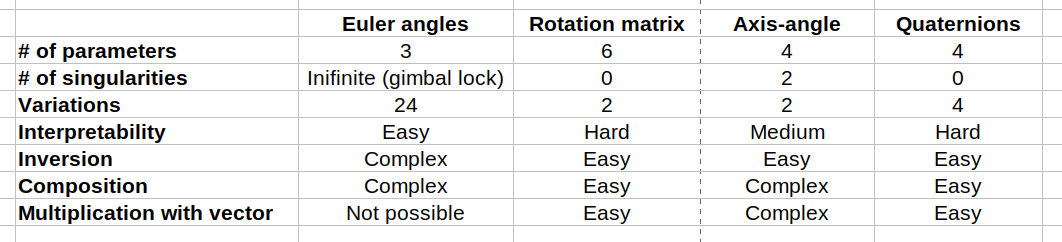

In [59]:
def r_x_12(x, pts_model, pts_target):
    x_R = x[0:9]
    R = x_R.reshape(3,3)
    return ((R @ pts_model.T).T + np.array([x[9:12]]) - pts_target).ravel()

x_gt_12 = np.hstack((R_gt.ravel(), x_gt[3:6]))
print('Check r_x_12 ( =0): ', np.linalg.norm(r_x_12(x_gt_12, pts_model, pts_target)))

Check r_x_12 ( =0):  0.0


In [60]:
#x0 = np.array([45.0-1.0, -15.0+2.0, 20.0+1.0, 1.0+0.5, -2.0+0.8, 3.0-0.2])
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
x0[:3] *= 1.0/180.0*math.pi
R0_12 = Rotation.from_euler('ZYX', x0[:3], degrees=False).as_matrix()
x0_12 = np.hstack((R0_12.ravel(), x0[3:6]))

In [61]:
res = minimize(lambda x: np.linalg.norm(r_x_12(x, pts_model, pts_target)), x0_12, method='trust-constr',
               options={'disp': True, 'maxiter': 2000})

`xtol` termination condition is satisfied.
Number of iterations: 164, function evaluations: 2132, CG iterations: 489, optimality: 9.42e-02, constraint violation: 0.00e+00, execution time: 0.52 s.


It's less suprising that the optimizer converged, bus it is more supresing that the optimizer actually found the solution! Check it out:

In [62]:
R_hat_12 = res.x[0:9].reshape(3,3)
print('Final cost: ', np.linalg.norm(r_x_12(res.x, pts_model, pts_target)))
print('Solutions as angles: ', Rotation.from_matrix(R_hat_12).as_euler('ZYX', degrees=True))
print(' ')
print('Compare solution to GT: ( =0)', np.linalg.norm(res.x - x_gt_12))
print('Compare rotation matrix to GT: ( =0)', np.linalg.norm(R_gt - R_hat_12))
print('Check rotation m. orthogonality: ( =0): ', np.linalg.norm(R_hat_12.T @ R_hat_12 - np.eye(3)))
print('Check rotation m. determinant ( =1): ', np.linalg.det(R_hat_12))
print('GT determinant ( =1): ', np.linalg.det(R_gt))

Final cost:  4.721843386442401e-06
Solutions as angles:  [ 45.00019924 -14.99994889  19.99977722]
 
Compare solution to GT: ( =0) 4.210128310220037e-05
Compare rotation matrix to GT: ( =0) 9.043242121203117e-06
Check rotation m. orthogonality: ( =0):  1.4919570581640394e-05
Check rotation m. determinant ( =1):  0.9999930005786255
GT determinant ( =1):  0.9999999999999993


The Euler angles look pretty close to the ground truth, and the orthogonality condition is automatically satisfied without constraints. So I thought this is because the system is overdetermined. Let's see the results when I pick the minimum problem (with the minimum number of points):

In [63]:
res = minimize(lambda x: np.linalg.norm(r_x_12(x, pts_model[:4], pts_target[:4])), x0_12, method='trust-constr',
               options={'disp': True, 'maxiter': 2000})

R_hat_12 = res.x[0:9].reshape(3,3)

print('Final cost: ', np.linalg.norm(r_x_12(res.x, pts_model[:4], pts_target[:4])))
print('Solutions as angles: ', Rotation.from_matrix(R_hat_12).as_euler('ZYX', degrees=True))
print(' ')
print('Check rotation m. orthogonality: ( =0): ', np.linalg.norm(R_hat_12.T @ R_hat_12 - np.eye(3)))
print('Check rotation m. determinant ( =1): ', np.linalg.det(R_hat_12))

`xtol` termination condition is satisfied.
Number of iterations: 212, function evaluations: 2756, CG iterations: 700, optimality: 4.76e-02, constraint violation: 0.00e+00, execution time: 0.78 s.
Final cost:  2.6580712280948095e-06
Solutions as angles:  [ 44.99960891 -15.00017402  20.00031089]
 
Check rotation m. orthogonality: ( =0):  2.4270170743247347e-05
Check rotation m. determinant ( =1):  0.9999938852012928


It's quite good! I need to go to an underdetermined case to get non-orthogonal solution for the rotation matrix:

In [64]:
x0 = np.array([45.0-10.0, -15.0+2.0, 20.0+1.0, 1.0+0.5, -2.0+0.8, 3.0-0.2])
x0[:3] *= 1.0/180.0*math.pi
R0_12 = Rotation.from_euler('ZYX', x0[:3], degrees=False).as_matrix()
x0_12 = np.hstack((R0_12.ravel(), x0[3:6]))

res = minimize(lambda x: np.linalg.norm(r_x_12(x, pts_model[:3], pts_target[:3])), x0_12, method='trust-constr',
               options={'disp': True, 'maxiter': 2000})

R_hat_12 = res.x[0:9].reshape(3,3)

print('Final cost: ', np.linalg.norm(r_x_12(res.x, pts_model[:4], pts_target[:4])))
print('Solutions as angles: ', Rotation.from_matrix(R_hat_12).as_euler('ZYX', degrees=True))
print(' ')
print('Check rotation m. orthogonality: ( =0): ', np.linalg.norm(R_hat_12.T @ R_hat_12 - np.eye(3)))
print('Check rotation m. determinant ( =1): ', np.linalg.det(R_hat_12))

`xtol` termination condition is satisfied.
Number of iterations: 136, function evaluations: 1768, CG iterations: 364, optimality: 1.88e-01, constraint violation: 0.00e+00, execution time: 0.66 s.
Final cost:  0.10350074748931755
Solutions as angles:  [ 45.59805758 -20.06082518  23.90786616]
 
Check rotation m. orthogonality: ( =0):  0.3045045381848295
Check rotation m. determinant ( =1):  1.0270571735897855


So now I can show-case how to fix this issue with constraints.

In [65]:
const = ({'type': 'eq', 'fun': lambda x:  (x[0:9].reshape(3,3).T @ x[0:9].reshape(3,3) - np.eye(3))[0,0]},
        {'type': 'eq', 'fun': lambda x:  (x[0:9].reshape(3,3).T @ x[0:9].reshape(3,3) - np.eye(3))[0,1]},
        {'type': 'eq', 'fun': lambda x:  (x[0:9].reshape(3,3).T @ x[0:9].reshape(3,3) - np.eye(3))[0,2]},
        {'type': 'eq', 'fun': lambda x:  (x[0:9].reshape(3,3).T @ x[0:9].reshape(3,3) - np.eye(3))[1,0]},
        {'type': 'eq', 'fun': lambda x:  (x[0:9].reshape(3,3).T @ x[0:9].reshape(3,3) - np.eye(3))[1,1]},
        {'type': 'eq', 'fun': lambda x:  (x[0:9].reshape(3,3).T @ x[0:9].reshape(3,3) - np.eye(3))[1,2]},
        {'type': 'eq', 'fun': lambda x:  (x[0:9].reshape(3,3).T @ x[0:9].reshape(3,3) - np.eye(3))[2,0]},
        {'type': 'eq', 'fun': lambda x:  (x[0:9].reshape(3,3).T @ x[0:9].reshape(3,3) - np.eye(3))[2,1]},
        {'type': 'eq', 'fun': lambda x:  (x[0:9].reshape(3,3).T @ x[0:9].reshape(3,3) - np.eye(3))[2,2]})

res = minimize(lambda x: np.linalg.norm(r_x_12(x, pts_model[:4], pts_target[:4])), x0_12, method='trust-constr',
               options={'disp': True, 'maxiter': 2000}, constraints=const)

R_hat_12 = res.x[0:9].reshape(3,3)

print('Final cost: ', np.linalg.norm(r_x_12(res.x, pts_model[:4], pts_target[:4])))
print('Solutions as angles: ', Rotation.from_matrix(R_hat_12).as_euler('ZYX', degrees=True))
print(' ')
print('Check rotation m. orthogonality: ( =0): ', np.linalg.norm(R_hat_12.T @ R_hat_12 - np.eye(3)))
print('Check rotation m. determinant ( =1): ', np.linalg.det(R_hat_12))

/home/zoltan/env/uni/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/zoltan/env/uni/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 299, function evaluations: 4186, CG iterations: 872, optimality: 2.35e-01, constraint violation: 3.75e-17, execution time:  3.6 s.
Final cost:  4.256463228857064e-07
Solutions as angles:  [ 44.99998947 -15.0000267   20.0000203 ]
 
Check rotation m. orthogonality: ( =0):  6.377622042195026e-17
Check rotation m. determinant ( =1):  1.0


Of course having 9 parameters to describe the rotation is not ideal. For one, Euler parameterization converges faster:

In [66]:
x0 = np.array([0, 0, 0, 0, 0, 0]) # converges to the solution in 149 iterations
res = minimize(lambda x: np.linalg.norm(r_x(x)), x0, method='trust-constr',
               options={'disp': True, 'maxiter': 2000})

`xtol` termination condition is satisfied.
Number of iterations: 139, function evaluations: 973, CG iterations: 491, optimality: 2.46e+00, constraint violation: 0.00e+00, execution time: 0.35 s.


# Soltuion #10: Changing parametrization: rotation vector

In [67]:
from scipy.spatial.transform import Rotation

In [68]:
rvec_gt = Rotation.from_euler('ZYX', ypr_gt, degrees=False).as_rotvec(degrees=False)
print('Rotation vector:', rvec_gt)
print('Rotation angle around the axis (omega):', np.linalg.norm(rvec_gt) / pi * 180)
print('Rotation axis: ', rvec_gt / np.linalg.norm(rvec_gt))

Rotation vector: [ 0.43196068 -0.1096754   0.81847044]
Rotation angle around the axis (omega): 53.39624175652324
Rotation axis:  [ 0.46350685 -0.11768502  0.8782435 ]


The converstion takes two steps: first from vector space to so(3), and then from so(3) to SO(3). I'm following here the lecture notes on [Lie Groups for 2D and 3D Transformations by Ethan Eade](https://www.ethaneade.com/lie.pdf).

Generator system to compute the skew symmetric matrix:

In [69]:
G1 = np.array([[0, 0, 0], [0, 0, -1], [0, 1, 0]])
G2 = np.array([[0, 0, 1], [0, 0, 0], [-1, 0, 0]])
G3 = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 0]])

Then, we can write the function that converts from rotation vector representation (R^3) to skew symmetric matrix (so(3)):

In [70]:
skew = lambda w: w[0]*G1 + w[1]*G2 + w[2]*G3

Note that the skew symmetric matrix allows for descring cross product with purely using matrix multiplication. In this sense the skew matrix can be viewed as "changing" the group operation from cross product to matrix-vector multiplication (R^3, x) = (R^3, []_x*) . Since both operations results in the exactly the same results applied on the all R^3 vectors, therefore the two groups are isomorphic.  

In [71]:
w_a = [-2, 3, 1]
w_b = np.array([4, -8, 2]).reshape(-1)

print('[a]_x * b = ', skew(w_a) @ w_b)
print('a x b =, ', np.cross(w_a, w_b))

[a]_x * b =  [14  8  4]
a x b =,  [14  8  4]


Then we can take the skew matrix (so(3)) and apply the exponential map to it; the result is the rotation matrix. The derivation can be found in a lecture notes titled [Lie Groups for 2D and 3D Transformations by Ethan Eade, Page 3-4](https://www.ethaneade.com/lie.pdf). This conversion formula is also known as the Rodrigues' rotation formula, see it on [Wikipedia](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula) : 

In [72]:
omega_gt = np.sqrt(rvec_gt.T @ rvec_gt) # = np.linalg.norm(rvec)
S_gt = skew(rvec_gt)
R_gt_lie = np.eye(3) + (math.sin(omega_gt)/omega_gt)*S_gt + ((1-math.cos(omega_gt))/omega_gt**2)*S_gt@S_gt

In [73]:
#R_gt = Rotation.from_euler('ZYX', ypr_gt, degrees=False).as_matrix()
print('Check calculation: ', np.linalg.norm(R_gt_lie - R_gt))

Check calculation:  4.263892432392673e-16


Let's do exponential map in a more compact form:

In [74]:
def Exp_(w):
    omega = (w[0]**2 + w[1]**2 + w[2]**2)**(1/2)
    S = np.array([[0, -w[2], w[1]], [w[2], 0, -w[0]], [-w[1], w[0], 0]])
    return np.eye(3) + (math.sin(omega)/omega)*S + ((1-math.cos(omega))/omega**2)*S@S

print('Check exponential map: ', np.linalg.norm(Exp_(rvec_gt) - R_gt))

Check exponential map:  4.263892432392673e-16


Reverse direction is easier:

In [75]:
def Log_(R):
    omega = np.arccos((np.trace(R)-1)/2)           # input rotation matrix
    S = (omega/(2*np.sin(omega))) * (R-R.T)        # rotation matrix SO(3) -> skew so(3)
    return [S[2, 1], S[0, 2], S[1, 0]]             # so(3) -> R^3, using the def. of skew matrix

print('Check log map: ', np.linalg.norm(Log_(R_gt) - rvec_gt))

Check log map:  3.554447978966673e-16


In [76]:
r_x_lie = lambda x0: ((Exp_(x0) @ pts_model.T).T + np.array([x0[3:6]]) - pts_target).ravel()
x_gt_lie = np.hstack((rvec_gt, x_gt[3:6]))
print('Check residual function ( =0): ', np.linalg.norm(r_x_lie(x_gt_lie)))

Check residual function ( =0):  4.318467880798754e-15


Let's compare the rotation vector parametrization with the Euler angle implementation using the built-in Nelder-Mead algorithm. As a reminder, here we want to directly solve the cost function, and we need to provide relatively good initial guess for convergence. 

In [77]:
x0_lie = np.array([45.0-15.0, -15.0+25.0, 20.0+25.0, 1.0+1.5, -2.0+1.8, 3.0-1.2]) # converging to the solution in ~1000 iterations
#x0_lie = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1]) # converging to a local minimum
x0_lie[:3] *= 1.0/180.0*math.pi

print('Solution with Euler angles: ')
res = minimize(lambda x: np.linalg.norm(r_x(x)), x0_lie, method='nelder-mead',
               options={'xatol': 1e-6, 'disp': True, 'maxiter': 2000})
print('Check Euler angle solution ( =0): ', np.linalg.norm(res.x - x_gt))

print(' ')

print('Solution with rotation vectors: ')
x0_lie[:3] = Rotation.from_euler('ZYX', x0_lie[:3], degrees=False).as_rotvec(degrees=False)
res = minimize(lambda x: np.linalg.norm(r_x_lie(x)), x0_lie, method='nelder-mead',
               options={'xatol': 1e-6, 'disp': True, 'maxiter': 2000})

print('Check rotation vector solution ( =0): ', np.linalg.norm(res.x - x_gt_lie))

Solution with Euler angles: 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 914
         Function evaluations: 1434
Check Euler angle solution ( =0):  3.1873147736009076e-07
 
Solution with rotation vectors: 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 847
         Function evaluations: 1301
Check rotation vector solution ( =0):  4.3273183160379225e-07


Both algorithm converged with some initial guess, but starting at very poor initial guess (close to zero), both approaches fail. Seemingly, the rotation vector representation converges faster, which is why this approach is preferred in practice. 

Advantages:
- In general, using rotation vector representation results in faster convergence than the Euler angle representation, and therefore, it's preferred in practice. 
- Only one singular point, when in case of zero rotation, and it can be easily handled.

Drawbacks:
- This approach does not converge with deravtive-free optimizer when the initial guess is very poor. 
- When trying to debug the code, representation of rotation vectors is not easy to interpret. In practice the covariances of the Euler angles are easier to interpret as opposed to the rotation vectors'.

# Operation counts with automatic differentation

In [78]:
import functools

In [79]:
class OperationCounterClass(object):
    table = {}

    @staticmethod
    def reset():
        for key in OperationCounter.table:
            OperationCounter.table[key] = 0
    
    @staticmethod
    def incr(op):
        if op in OperationCounter.table.keys():
            OperationCounter.table[op] += 1
        else:
            OperationCounter.table[op] = 1         

    def __repr__(self):
        return str(self.table)

OperationCounter = OperationCounterClass() # so __repr__ works as expected

def operation_counter_decorator(func):
    OperationCounter.table[func.__name__] = 0
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if len(args) == 1:
            OperationCounter.incr(func.__name__)   
        elif len(args) == 2:
            self = args[0]
            other = args[1]
            if isinstance(other, Variable): # would be called twice if 'other' needs casting
                OperationCounter.incr(func.__name__)   
        else:
            raise NotImplementedError
                        
        return func(*args, **kwargs)
    return wrapper

In [80]:
class VariableCnt(Variable):
       
    def __init__(self, value, local_gradients=[]):
        if isinstance(value, Variable):  
            Variable.__init__(self, value.value, value.local_gradients)
        else:
            Variable.__init__(self, value, local_gradients)
    
    @operation_counter_decorator
    def __add__(self, other):
        return VariableCnt(Variable.__add__(self, other))
    
    @operation_counter_decorator
    def __mul__(self, other):
        return VariableCnt(Variable.__mul__(self, other))

    @operation_counter_decorator
    def __neg__(self):
        return VariableCnt(Variable.__neg__(self))
    
    #@operation_counter # VariableCnt.var_operation_count['sub'] += 1 # subtraction is composed of neg and add so here we would duplicate count
    def __sub__(self, other):
        return VariableCnt(Variable.__sub__(self, other)) 
    
    __radd__  = __add__
    __rmul__ = __mul__
    __rsub__ = __sub__
    
class VarFunctionsCnt(VarFunctions):
    @staticmethod
    @operation_counter_decorator
    def sin(a):
        return VariableCnt(VarFunctions.sin(a))
    
    @staticmethod
    @operation_counter_decorator
    def cos(a):
        return VariableCnt(VarFunctions.cos(a))

vf = VarFunctionsCnt

In [81]:
OperationCounter.reset()

test_a = VariableCnt(1)
test_b = VariableCnt(2)
test_c = (test_a - vf.cos(test_b))*2

print('Operation types and counts: ', OperationCounter)
print('Value at the last variable ( !=0): ', test_c.value)
print('Gradients at the last variable (= not []): ', test_c.local_gradients)

Operation types and counts:  {'__add__': 1, '__mul__': 1, '__neg__': 1, 'sin': 0, 'cos': 1}
Value at the last variable ( !=0):  2.8322936730942847
Gradients at the last variable (= not []):  ((1.4161468365471424v, 2.0), (2.0v, 1.4161468365471424))


In [82]:
def Rx_(theta):
  return np.array([[ 1, 0           , 0           ],
                   [ 0, vf.cos(theta),-vf.sin(theta)],
                   [ 0, vf.sin(theta), vf.cos(theta)]])
  
def Ry_(theta):
  return np.array([[vf.cos(theta), 0, vf.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-vf.sin(theta), 0, vf.cos(theta)]])
  
def Rz_(theta):
  return np.array([[vf.cos(theta), -vf.sin(theta), 0 ],
                   [ vf.sin(theta), vf.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

np2var = lambda vec, typeOf=VariableCnt: [typeOf(x) for x in vec]
ypr2rot_ad = lambda x: Rz_(x[0]) @ Ry_(x[1]) @ Rx_(x[2])
r_x_ad = lambda x0: ((ypr2rot_ad(x0) @ pts_model.T).T + np.array([x0[3:6]]) - pts_target).ravel()

Run a Gauss-Newton just to check that everything's ok...

In [83]:
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # converging to the solution in 5 iterations

def gauss_newton_autodiff_count_step(x):
    x_ad = np2var(x)
    dr_ad = r_x_ad(x_ad)
    dr_f = dr_ad.astype('float')
    J_ad = build_J_ad(dr_ad, x_ad)
    
    dx = np.linalg.inv(J_ad.T @ J_ad) @ J_ad.T @ dr_f    
    return dx

optimizer_framework(gauss_newton_autodiff_count_step, x0, x_gt)

Iteration #        delta gt           dx              dr                  
----------------------------------------------------------------
Iteration #0      3.84801717             nan    497.62780943
Iteration #1      1.51626838      4.81285259      3.25424394
Iteration #2      0.08253915      1.48703868      0.26340997
Iteration #3      0.00005337      0.08252769      0.00020193
Iteration #4      0.00000000      0.00005337      0.00000000
Iteration #5      0.00000000      0.00000000      0.00000000
Check solution ( =0):  3.906739001172201e-15


In [84]:
OperationCounter.reset()

x0_ad = np2var(x0)
dr_ad = r_x_ad(x0_ad)
J_ad = build_J_ad(dr_ad, x0_ad)

print('To be sure that type is correct ( =True): ', type(dr_ad[0]) is VariableCnt)
print('Operations counts:', OperationCounter) # {'add': 154, 'mul': 136, 'neg': 3, 'sin': 6, 'cos': 6}

To be sure that type is correct ( =True):  True
Operations counts: {'__add__': 154, '__mul__': 136, '__neg__': 3, 'sin': 6, 'cos': 6}


# Soltuion #10: Automatic differentation with rotation vectors

In [85]:
class VariableExt(VariableCnt):
            
    def __init__(self, value, local_gradients=[]):
        VariableCnt.__init__(self, value, local_gradients)
    
    def __pow__(self, other):
        if isinstance(other, Variable) and other.value == 2: 
            OperationCounter.incr('pow2')
        elif isinstance(other, Variable) and other.value == 0.5: 
            OperationCounter.incr('sqrt')
        elif isinstance(other, Variable) and other.value < 1.0: 
            OperationCounter.incr('invpow')
        elif isinstance(other, Variable):
            OperationCounter.incr('pow')
        
        if not isinstance(other, Variable):
            return self.__pow__(VariableExt(float(other)))                
        value = self.value ** other.value
        local_gradients = ((self,  other.value*self.value**(other.value-1) ), 
                           (other, self.value**other.value*math.log(other.value)))
        return VariableExt(value, local_gradients)
             
    @operation_counter_decorator        
    def __inv__(self):
        value = 1. / self.value
        local_gradients = (
            (self, -1 / self.value**2),
        )
        return VariableExt(value, local_gradients)
        
    def __truediv__(self, other):
        if not isinstance(other, Variable):
            return self.__truediv__(VariableExt(float(other)))         
        return self.__mul__(other.__inv__()) 

    def __add__(self, other):
        return VariableExt(VariableCnt.__add__(self, other))
    
    def __mul__(self, other):
        return VariableExt(VariableCnt.__mul__(self, other))

    def __neg__(self):
        return VariableExt(VariableCnt.__neg__(self))
    
    def __sub__(self, other):
        return VariableExt(VariableCnt.__sub__(self, other)) 
    
    __radd__  = __add__
    __rmul__ = __mul__
    __rsub__ = __sub__
        
class VarFunctionsExt(VarFunctionsCnt):

    @staticmethod
    def sin(a):
        if not isinstance(a, Variable):
            return VarFunctionsExt.sin(VariableExt(float(a)))                
        return VariableExt(VarFunctionsCnt.sin(a))
    
    @staticmethod
    def cos(a):
        if not isinstance(a, Variable):
            return VarFunctionsExt.cos(VariableExt(float(a)))                
        return VariableExt(VarFunctionsCnt.cos(a))

vf = VarFunctionsExt
_var = VariableExt

In [86]:
OperationCounter.reset()

test_a = _var(3)
test_b = _var(4)
test_c = (test_a**2 + test_b**2)**(_var(1)/_var(2))
print('Test value ( =5): ', test_c.value)
print('Local gradient ( not =[]): ', test_c.local_gradients)

print('Number of operations: ', OperationCounter)

Test value ( =5):  5.0
Local gradient ( not =[]):  ((25.0v, 0.1), (0.5v, -3.4657359027997265))
Number of operations:  {'__add__': 1, '__mul__': 1, '__neg__': 0, 'sin': 0, 'cos': 0, '__inv__': 1, 'pow2': 2, 'sqrt': 1}


In [87]:
x_gt_al = np.hstack((rvec_gt, x_gt[3:6]))

def Exp_al_(w):
    omega = (w[0]**2 + w[1]**2 + w[2]**2)**(1/2) # some modification here, because we need to use elementary operations
    S = np.array([[0, -w[2], w[1]], [w[2], 0, -w[0]], [-w[1], w[0], 0]])
    # need to change the scalar * matrix order to matrix * scalar & convert all constants to VariableExt
    R = np.eye(3) + S*(vf.sin(omega)/omega) + S@S*((_var(1)-vf.cos(omega))/omega**2)
    return R

R_gt_al = Exp_al_(np2var(x_gt_al, typeOf=VariableExt))
print(np.linalg.norm((R_gt_al - R_gt).astype('float')))
print(R_gt_al[0,0].local_gradients)
print(type(R_gt_al[0, 0]))

5.662749647834299e-16
((1.0v, 1.0), (-0.31698729810778076v, 1.0))
<class '__main__.VariableExt'>


In [88]:
r_x_al = lambda x0: ((Exp_al_(x0) @ pts_model.T).T + np.array([x0[3:6]]) - pts_target).ravel()
print('Check residual function ( =0): ', np.linalg.norm(r_x_al(x_gt_al).astype('float')))

Check residual function ( =0):  4.79071205159252e-15


In [89]:
def gauss_newton_rvec_step(x):
    x_al = np2var(x, typeOf=VariableExt)
    dr_al = r_x_al(x_al)
    dr_f = dr_al.astype('float')
    J_al = build_J_ad(dr_al, x_al)
    dx = np.linalg.inv(J_al.T @ J_al) @ J_al.T @ dr_f
    return dx

x0 = np.array([0.001, 0, 0, 0.0, 0.0, 0.0]) # converging to the solution in 5 iterations
optimizer_framework(gauss_newton_rvec_step, x0, x_gt_al)

Iteration #        delta gt           dx              dr                  
----------------------------------------------------------------
Iteration #0      3.85585913             nan    497.67711453
Iteration #1      1.51024789      4.81104212     10.60582925
Iteration #2      0.05196069      1.49141698      7.50595213
Iteration #3      0.00001699      0.05194708      7.38709342
Iteration #4      0.00000000      0.00001699      7.38707522
Iteration #5      0.00000000      0.00000000      7.38707522
Check solution ( =0):  2.0337470709422124e-15


In [90]:
OperationCounter.reset()

x0_al = np2var(x0, typeOf=VariableExt)
dr_al = r_x_al(x0_al)
J_al = build_J_ad(dr_al, x0_al)

print('To be sure that type is correct ( =True): ', type(dr_ad[0]) is VariableExt)
print('Operation count: ', OperationCounter)
# Euler angles were: {'add': 154, 'mul': 136, 'neg': 3, 'sin': 6, 'cos': 6}

To be sure that type is correct ( =True):  False
Operation count:  {'__add__': 159, '__mul__': 134, '__neg__': 4, 'sin': 1, 'cos': 1, '__inv__': 2, 'pow2': 4, 'sqrt': 1}


TODO: rotation matrix unknowns with lie algebra and automatic differentation

# Soltuion #11: "Optimization on manifold"

- https://www.ethaneade.com/lie.pdf
- Graph-base SLAM tutorial: http://ais.informatik.uni-freiburg.de/teaching/ws11/robotics2/pdfs/ls-slam-tutorial.pdf
- GTSAM: https://github.com/borglab/gtsam/blob/develop/doc/LieGroups.pdf
- https://www.ri.cmu.edu/wp-content/uploads/2018/08/jerry_thesis.pdf
- Formulas: https://jinyongjeong.github.io/Download/SE3/jlblanco2010geometry3d_techrep.pdf
- https://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=EBB42B22A92830B0957092094A971A67?doi=10.1.1.37.5009&rep=rep1&type=pdf

The theme will be the followings:

TODO: this need to be in a reverse direction!

1. We have a known rotation representation (e.g. rotation matrix, quaternion) to simply perform an "action" called rotation on points represented with 3D vectors. However these representations are over-parametrizations of the rotation (for rotation matrix it is 9 and for quaternion it is 4 vs. the minimal representation composed of only 3 parameters). We saw that we needed constraints when using non-minimal rotation representation. To avoid using constraints, We consider special properties of these transformations. These transformations are special mathematical structures called  Lie groups, i.e. SO(3) for rotation matrices and S(4) for quaternions.

2. We will have conversion from the Lie group to another mathematical structure called the Lie algebra. The Lie algebra of rotation matrices is so(3) skew matrices and for quaternions it is S(3) unit quaternions. This conversion or mapping between the group and its algebra is called the logarithmic  map. 

3. The Lie algebra is isomorphic with an n-dimensional vector space. In our case, it means that for each element of so(3) or S(3) I can assign a vector from a 3D vector space. Therefore, we will have a R^3 minimal represention of rotations in the continous vector space. Then, we can optimization without having worried about constraints, however we don't have a direct mathematical formula to apply rotation on a point represented by a vector as we had in the Lie groups.

These steps can be reversed. In this case we need to invert the logarithmic map; this mapping is called exponential map. During optimization we can do both operations to change from one representation to the other depending on whether we perform the rotation or update the optimizer step. 

Dictionary:
- Lie groups: rotation representation with wich we can directly perform rotation, e.g. rotation matrix, quaternion.
- Lie algebra: some intermidiate representation between the Lie group and R^3, e.g. skew matrix for rotation matrix and unit quaternions for quaternions.
- exponential map: conversion
- logarithmic map: conversion
- isomporphic: basically the same space just operations defined a bit differently

Let's visualize these mathematical structures and make sense of it:

/tmp/ipykernel_174247/2765266935.py:14: RuntimeWarning: invalid value encountered in scalar divide
  S = (omega/(2*np.sin(omega))) * (R - R.T)      # SO(3) -> so(3)


Text(0.5, 0.92, 'SO(3) Lie group of rotation matrices and\n so(3) Lie algebra of skew matrices')

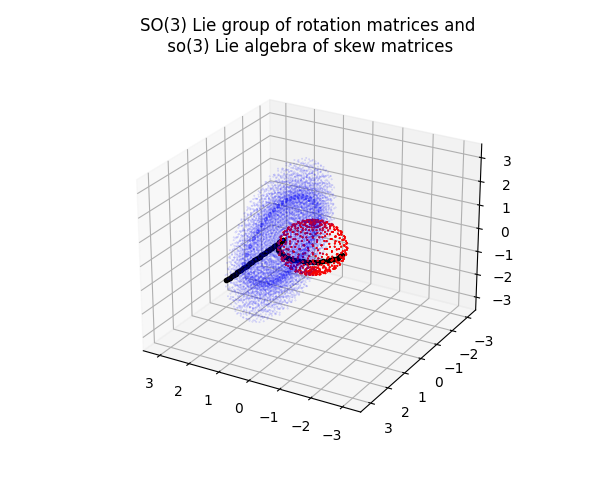

In [91]:
tangent_pt = np.array([1, 0, 0])

# Let's create the surfaces by visualizing their transformation on a 3D vector tangent_pt
SO3_surface = []
so3_surface = []
for yaw in np.arange(-pi, pi, 0.3):                    # sample points at possible Euler 
  for pitch in np.arange(-pi, pi, 0.3):                # angles to construct SO(3)
    for roll in np.arange(-pi, pi, 0.3):
        R = R_x([yaw, pitch, roll])                    # construct rotation matrix SO(3)
        pt_ = R @ tangent_pt                         
        SO3_surface.append(pt_)
        
        omega = np.arccos((np.trace(R)-1)/2)        
        S = (omega/(2*np.sin(omega))) * (R - R.T)      # SO(3) -> so(3)
        pt_ = S @ tangent_pt
        so3_surface.append(pt_)

SO3_surface = np.array(SO3_surface)
so3_surface = np.array(so3_surface)
so3_surface += tangent_pt                              # this will move the points to the identity SO(3) * tangent_pt

# plotting the SO(3) and so(3) surfaces
plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')
ax.scatter3D(SO3_surface[:,0], SO3_surface[:,1], SO3_surface[:,2], c='r', s=0.1, alpha=0.2)
ax.scatter3D(so3_surface[:,0], so3_surface[:,1], so3_surface[:,2], c='b', s=0.1, alpha=0.2)

# We will create a trajectory in R^3 and show how this trajectory looks like in so(3) and SO(3)
SO3_line = []
so3_line = []
for w_i in np.arange(0.0001, pi, 0.1):
    w = [0, 0, w_i]
    S = np.array([[0, -w[2], w[1]], [w[2], 0, -w[0]], [-w[1], w[0], 0]])            # R^3 -> so(3)
    pt_ = S @ tangent_pt
    so3_line.append(pt_)

    omega = (w[0]**2 + w[1]**2 + w[2]**2)**(1/2)
    R = np.eye(3) + (math.sin(omega)/omega)*S + ((1-math.cos(omega))/omega**2)*S@S  # so(3) -> SO(3)
    pt_ = R @ tangent_pt
    SO3_line.append(pt_)

SO3_line = np.array(SO3_line)
so3_line = np.array(so3_line)
so3_line += tangent_pt 

# plotting the trajectory
ax.plot3D(SO3_line[:,0], SO3_line[:,1], SO3_line[:,2], 'k.-', markersize=6)
ax.plot3D(so3_line[:,0], so3_line[:,1], so3_line[:,2], 'k.-', markersize=6)
set_3d_axes_equal(ax)
ax.view_init(elev=25, azim=120)
ax.set_title('SO(3) Lie group of rotation matrices and\n so(3) Lie algebra of skew matrices')

In [92]:
def skew_al(x): return np.array([[_var(0), -x[2], x[1]],
                                 [x[2], _var(0), -x[0]],
                                 [-x[1], x[0], _var(0)]])

R0 = Exp_([0.0001, 0.0, 0.0])
t0 = np.array([0.0, 0.0, 0.0])
dx = np.inf
iter_num = 0

print('Iteration #{:d} \t R: {:.6f} \t t: {:.4f} \t dx: {:.8f}\t dr: {:.8f}'.format(
         iter_num, np.linalg.norm(R0 - R_gt), np.linalg.norm(t0 - t_gt), dx, np.nan))

while np.linalg.norm(dx) > 1e-6 and iter_num < 100:
    iter_num += 1
    
    dr = (((R0 @ pts_model.T).T + t0.reshape(1,-1)) - pts_target).ravel()    
    #w = Log_(R0)                                                  # S0(3) => so(3) => R^3
    w = [0.0001, 0.0, 0.0]
    
    # step computation
    x_al = np2var(np.hstack([w, t0]), typeOf=VariableExt)         # Create auto-differentiable variables
    # Use small angle approximation here: Exp_al_(x0) == R0 @ skew_al(x0[:3])
    r_x_al = lambda x0: (( R0 @ skew_al(x0[:3]) @ pts_model.T).T + (t0 + np.array([x0[3:6]])) - pts_target).ravel()
    dr_al = r_x_al(x_al)
    J_al = build_J_ad(dr_al, x_al)                                # Jacobian on R^3
    dx = np.linalg.solve(-J_al.T @ J_al, J_al.T @ dr)              # Solution on R^3
    
    # update
    R0 = R0 @ Exp_(dx[:3])                                        # incremental update: R^3 => so(3) => SO(3)
    t0 = t0 + dx[3:6]
    print('Iteration #{:d} \t R: {:.6f} \t t: {:.4f} \t dx: {:.8f}\t dr: {:.8f}'.format(
         iter_num, np.linalg.norm(R0 - R_gt), np.linalg.norm(t0 - t_gt), np.linalg.norm(dx), np.linalg.norm(dr)))
        
print('Check solution ( =0): ', np.linalg.norm(R0 - R_gt))

Iteration #0 	 R: 1.270725 	 t: 3.7417 	 dx: inf	 dr: nan
Iteration #1 	 R: 0.212963 	 t: 1.5044 	 dx: 4.81267141	 dr: 16.88866336
Iteration #2 	 R: 0.003323 	 t: 0.0520 	 dx: 1.49303516	 dr: 2.96656644
Iteration #3 	 R: 0.000001 	 t: 0.0000 	 dx: 0.05208177	 dr: 0.14885669
Iteration #4 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00001340	 dr: 0.00003678
Iteration #5 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00000000	 dr: 0.00000000
Check solution ( =0):  1.1281198993241301e-15


# Soltuion #12: "Optimization on manifold" with analytical Jacobians

We saw that above that the algorithm convergence exactly the same regardles how `w` was set. The reason behind this is that the elements of `w` vanish through differentiation. Let's see how the partial derivatives of the Jacobian look like:

$$
\frac{\partial \mathbf{r}(R_0 \Delta R, \mathbf{t}_0 + \Delta \mathbf{t})}{\partial \Delta R} =
\frac{\partial \mathbf{r}(R_0 Exp(\mathbf{\omega}), \mathbf{t}_0 + \Delta \mathbf{t})}{\partial \mathbf{\omega}} \approx
\frac{\partial \mathbf{r}(R_0[\mathbf{\omega}]_x, \mathbf{t}_0 + \Delta \mathbf{t})}{\partial \mathbf{\omega}} = 
-R[\mathbf{p}]_x,
$$

and

$$
\frac{\partial \mathbf{r}(R_0 \Delta R, \mathbf{t}_0 + \Delta \mathbf{t})}{\partial \Delta \mathbf{t}} = I_3.
$$


That's pretty easy to implement:

In [93]:
# for derivation, see https://github.com/borglab/gtsam/blob/develop/doc/LieGroups.pdf, Page 14
def build_J_manifold(R, pts_model):
    J_m_built = []
    for k in range(pts_model.shape[0]):
        pts = pts_model[k, :]
        J_pts = np.hstack([-R @ skew(pts), np.eye(3)])
        J_m_built.extend(J_pts.tolist())    
    return np.array(J_m_built)

J_chk = build_J_manifold(R_gt, pts_model)
print('Jacobian for one point: ')
print(J_chk[:3, :])
print('Jacobian construction check ( =0): ', np.linalg.norm(J_chk - J_al))

Jacobian for one point: 
[[ 2.78305766  2.35806736 -2.66805042  1.          0.          0.        ]
 [-3.02320868  3.2148366  -0.31409628  0.          1.          0.        ]
 [ 0.63374858 -0.66732321  0.06217518  0.          0.          1.        ]]
Jacobian construction check ( =0):  6.061214819215457e-13


And then we can call this function in out optimizer:

In [94]:
R0 = Exp_([0.0001, 0.0, 0.0])
t0 = np.array([0.0, 0.0, 0.0])
dx = np.inf
iter_num = 0

print('Iteration #{:d} \t R: {:.6f} \t t: {:.4f} \t dx: {:.8f}\t dr: {:.8f}'.format(
         iter_num, np.linalg.norm(R0 - R_gt), np.linalg.norm(t0 - t_gt), dx, np.nan))

while np.linalg.norm(dx) > 1e-6 and iter_num < 100:
    iter_num += 1
    
    dr = (((R0 @ pts_model.T).T + t0.reshape(1,-1)) - pts_target).ravel()    
    J_m_a = build_J_manifold(R_gt, pts_model)   
    dx = np.linalg.solve(-J_m_a.T @ J_m_a, J_m_a.T @ dr)                  
    R0 = R0 @ Exp_(dx[:3])                                        
    t0 = t0 + dx[3:6]
    
    print('Iteration #{:d} \t R: {:.6f} \t t: {:.4f} \t dx: {:.8f}\t dr: {:.8f}'.format(
         iter_num, np.linalg.norm(R0 - R_gt), np.linalg.norm(t0 - t_gt), np.linalg.norm(dx), np.linalg.norm(dr)))
        
print('Check solution ( =0): ', np.linalg.norm(R0 - R_gt))

Iteration #0 	 R: 1.270725 	 t: 3.7417 	 dx: inf	 dr: nan
Iteration #1 	 R: 0.214294 	 t: 1.5044 	 dx: 3.75390114	 dr: 16.88866336
Iteration #2 	 R: 0.004554 	 t: 0.0387 	 dx: 1.48833065	 dr: 4.06320513
Iteration #3 	 R: 0.000002 	 t: 0.0000 	 dx: 0.03883155	 dr: 0.08345232
Iteration #4 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00002365	 dr: 0.00006969
Iteration #5 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00000000	 dr: 0.00000000
Check solution ( =0):  1.4552500014939717e-15


# Quaternions with optimization on manifold 

In [95]:
#q0 = Rotation.from_euler('ZYX', ypr_gt, degrees=False).as_quat()
q_gt = Rotation.from_matrix(R_gt).as_quat()

In [96]:
def q_mult(q1, q2):
    x1, y1, z1, w1 = q1
    x2, y2, z2, w2 = q2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    return x, y, z, w

def q_conjugate(q):
    x, y, z, w = q
    return [-x, -y, -z, w]

# rotatate matrix of points with a given quaternion
def qv_mult(q1, v1):
    ret = []
    for k in range(v1.shape[0]):
        q2 = [v1[k, 0], v1[k, 1], v1[k, 2], 0.0]
        pv = q_mult(q_mult(q1, q2), q_conjugate(q1))
        ret.append(pv) # = q*v*q'
    return np.array(ret)[:, :3]

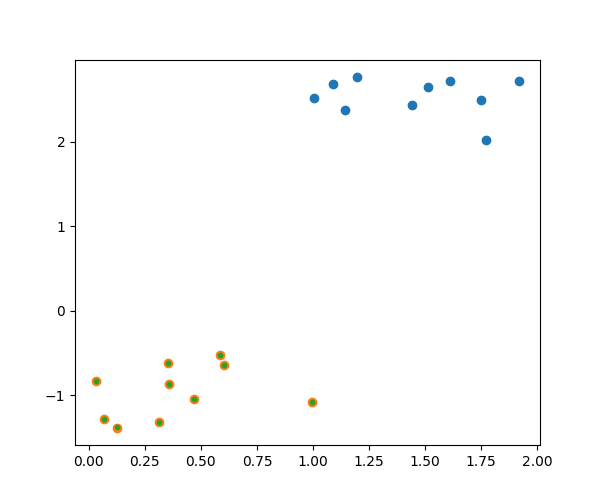

In [97]:
pts_model_hat = qv_mult(q_gt, pts_model) + t_gt

plt.figure(figsize=(6,5))
plt.scatter(pts_model[:, 0], pts_model[:, 1])
plt.scatter(pts_target[:, 0], pts_target[:, 1])
plt.scatter(pts_model_hat[:, 0], pts_model_hat[:, 1], s=10.0)


If we try to obtain the solution by directly optimizting the 4-element long unit quaternions, then the problem is underdetermined. To handle the underdetermined system, we need to introduce constraints. Instead, in practice, we can use the Lie algebra of the unit quaternion Lie-group, which would be the purely imagenery or simply pure quaternions with the same operations. The pure quaternions consist of 3 elements that can be directly solved in our optimizer.

In [98]:
q0 = Rotation.from_euler('ZYX', [0.0, 0.0, 0.0]).as_quat() # note: this is unit quaternion
t0 = np.array([0.0, 0.0, 0.0])
dx = np.inf
iter_num = 0

print('Iteration #{:d} \t q: {:.6f} \t t: {:.4f} \t dx: {:.8f}\t dr: {:.8f}'.format(
         iter_num, np.linalg.norm(q0 - q_gt), np.linalg.norm(t0 - t_gt), dx, np.nan))

# unit quaternion's exponential map is the purely imagenery quaternions ("pure quaternions") 
def Expq_(qp):
    om = np.sqrt(qp @ qp.T)
    a = np.sin(om/2)/om
    return [a*qp[0], a*qp[1], a*qp[2], np.cos(om/2)]

while np.linalg.norm(dx) > 1e-6 and iter_num < 100:
    iter_num += 1
    
    dr = (qv_mult(q0, pts_model) + t0 - pts_target).ravel()    
    
    # step computation
    x_aq = np2var(np.hstack([[0, 0, 0], t0]), typeOf=VariableExt)
    r_x_ag = lambda x0: (qv_mult(q_mult(q0, [x0[0], x0[1], x0[2], _var(1.0)]), pts_model) + np.array([x0[3:]]) - pts_target).ravel()
    dr_aq = r_x_ag(x_aq)
    J_aq = build_J_ad(dr_aq, x_aq, n=6)
    dx = np.linalg.solve(-J_aq.T @ J_aq, J_aq.T @ dr)
        
    # update
    q0 = q_mult(q0, Expq_(dx[:3]))
    t0 = t0 + dx[3:]
    
    print('Iteration #{:d} \t q: {:.6f} \t t: {:.4f} \t dx: {:.8f}\t dr: {:.8f}'.format(
         iter_num, np.linalg.norm(q0 - q_gt), np.linalg.norm(t0 - t_gt), np.linalg.norm(dx), np.linalg.norm(dr)))
        
print('Check solution ( =0): ', np.linalg.norm(q0 - q_gt))

Iteration #0 	 q: 0.461766 	 t: 3.7417 	 dx: inf	 dr: nan
Iteration #1 	 q: 0.265082 	 t: 1.5046 	 dx: 4.76178066	 dr: 16.88998476
Iteration #2 	 q: 0.139205 	 t: 0.5361 	 dx: 1.09046423	 dr: 3.96071353
Iteration #3 	 q: 0.070598 	 t: 0.1524 	 dx: 0.41718304	 dr: 2.59548981
Iteration #4 	 q: 0.035436 	 t: 0.0396 	 dx: 0.13362280	 dr: 1.42512282
Iteration #5 	 q: 0.017737 	 t: 0.0100 	 dx: 0.04617985	 dr: 0.73221071
Iteration #6 	 q: 0.008871 	 t: 0.0025 	 dx: 0.01925559	 dr: 0.36891896
Iteration #7 	 q: 0.004436 	 t: 0.0006 	 dx: 0.00906823	 dr: 0.18487750
Iteration #8 	 q: 0.002218 	 t: 0.0002 	 dx: 0.00446086	 dr: 0.09250679
Iteration #9 	 q: 0.001109 	 t: 0.0000 	 dx: 0.00222119	 dr: 0.04626582
Iteration #10 	 q: 0.000555 	 t: 0.0000 	 dx: 0.00110944	 dr: 0.02313544
Iteration #11 	 q: 0.000277 	 t: 0.0000 	 dx: 0.00055458	 dr: 0.01156828
Iteration #12 	 q: 0.000139 	 t: 0.0000 	 dx: 0.00027727	 dr: 0.00578427
Iteration #13 	 q: 0.000069 	 t: 0.0000 	 dx: 0.00013863	 dr: 0.00289217
I

# Timeit

In [99]:
%%timeit -r 5 -n 10
cog_model = np.mean(pts_model, axis=0)          # mean computation can be done in one loop: n_pts
cog_target = np.mean(pts_target, axis=0)        # 
pts_model_cog = pts_model - cog_model           # computing cog of points can be done in one loop
pts_target_cog = pts_target - cog_target        # 
C = pts_model_cog.T @ pts_target_cog            # n_pts * 3 * n_pts
[U, S, V] = np.linalg.svd(C) # this will be always the svd of a 3x3 matrix independently the number of points
R_svd = V.T @ U.T                               # some constant: 3*3*3
t_svd = cog_target - R_svd @ cog_model          # some constant

88.4 µs ± 21.7 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


Let's say something about the computation complexity:

- getting SVD of a 3x3 matrix is some constant
- number of $\mathcal{O}(N^2)$ operation: 3
- number of $\mathcal{O}(N)$ operation: 2

In [100]:
%%timeit -r 5 -n 10
x0 = np.array([0.001, 0, 0, 0.0, 0.0, 0.0])
dx = np.inf 
iter_num = 0
while np.linalg.norm(dx) > 1e-6 and iter_num < 100:
    iter_num += 1
    x0_al = np2var(x0, typeOf=VariableExt)
    dr_al = r_x_al(x0_al)
    J_al = build_J_ad(dr_al, x0_al)
    dr_f = dr_al.astype('float')
    #dx = np.linalg.inv(J_al.T @ J_al) @ J_al.T @ dr_f
    dx = np.linalg.solve(J_al.T @ J_al, J_al.T @ dr_f)
    x0 = x0 - dx

9.73 ms ± 2.38 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [101]:
%%timeit -r 5 -n 10
x0 = np.array([0, 0, 0, 0, 0, 0])
res = least_squares(r_x, x0, verbose=0, xtol=1e-6)

6.59 ms ± 1.96 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [102]:
def manifold_analytical(R0, t0):
    dx = np.inf
    iter_num = 0
    while np.linalg.norm(dx) > 1e-6 and iter_num < 100:
        iter_num += 1
        dr = (((R0 @ pts_model.T).T + t0.reshape(1,-1)) - pts_target).ravel()    
        J_m_a = build_J_manifold(R_gt, pts_model)   
        dx = np.linalg.solve(-J_m_a.T @ J_m_a, J_m_a.T @ dr)                  
        R0 = R0 @ Exp_(dx[:3])                                        
        t0 = t0 + dx[3:6]
    return R0, t0, J_m_a

In [103]:
%%timeit -r 50 -n 10
R0 = Exp_([0.0001, 0.0, 0.0])
t0 = np.array([0.0, 0.0, 0.0])
manifold_analytical(R0, t0)

The slowest run took 10.18 times longer than the fastest. This could mean that an intermediate result is being cached.
3.45 ms ± 1.94 ms per loop (mean ± std. dev. of 50 runs, 10 loops each)


In [104]:
n_pts = pts_model.shape[0]
pts_model_T = pts_model.T
pts_target_T = pts_target.T
I3 = np.ones((1, n_pts))
J_t = np.vstack([np.eye(3)]*n_pts)

def manifold_analytical_opt(R0, t0):
    dx = np.inf
    iter_num = 0
    J = np.hstack((np.zeros((n_pts*3, 3)), J_t))
    while np.linalg.norm(dx) > 1e-6 and iter_num < 100:
        iter_num += 1

        ### This part can be done in one loop: n_pts
        T_pts = np.hstack((R0, t0)) @ np.vstack((pts_model_T, I3))
        dr = (T_pts - pts_target_T).T.ravel()                  
        
        for k in range(n_pts):
            J[(k*3):(k*3+3), :3] = -R0 @ skew(pts_model[k, :])
            
        Jr = J.T @ dr
        ###
        
        # in general J.T @ J is n_pts*6*n_pts 
        # but the result is symmetric matrix so we need just the half
        dx = np.linalg.solve(-J.T @ J, Jr)                     
        
        R0 = R0 @ Exp_(dx[:3])                                 # some constant                   
        t0 = t0 + dx[3:6].reshape(3, 1)                        # some constant
    return R0, t0, J

In [105]:
%%timeit -r 50 -n 10
R0 = Exp_([0.0001, 0.0, 0.0])
t0 = np.array([[0.0], [0.0], [0.0]])
manifold_analytical_opt(R0, t0)

The slowest run took 11.88 times longer than the fastest. This could mean that an intermediate result is being cached.
3.73 ms ± 2.66 ms per loop (mean ± std. dev. of 50 runs, 10 loops each)


Let's say something about the computation complexity:

- solving linear equation system of 3x3 is some constant
- number of $\mathcal{O}(N^2)$ operation: C * 6
- number of $\mathcal{O}(N)$ operation: C * 1

where C is the number of iterations $\approx 5$.

How could we further improve on this? 

1. $J^T J$ results in a symmetric matrix, so we can just compute the half of the normal matrix.
2. The translation blocks of $J^T J$ is always the same since that block is constant, that's 3 paramters out of 6, so we don't need to compute 1/4th of the matrix.

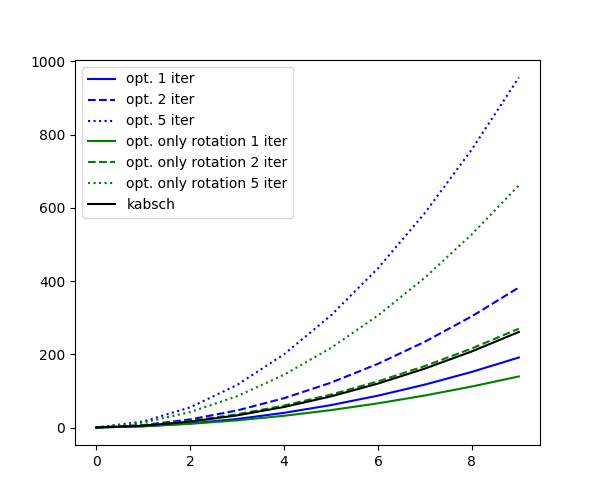

In [106]:
complexity_kabsch = lambda n: 3*n**2 + 2*n
complexity_manif = lambda n, c: c*(6*n**2/2 - 6*n**2/2/4 + n)
complexity_manif_R = lambda n, c: c*(3*n**2/2 + n) + n
n_pts_comp = np.arange(0, 10, 1)

plt.figure(figsize=(6,5))
plt.plot(n_pts_comp, complexity_manif(n_pts_comp, 1), 'b-', label='opt. 1 iter')
plt.plot(n_pts_comp, complexity_manif(n_pts_comp, 2), 'b--', label='opt. 2 iter')
plt.plot(n_pts_comp, complexity_manif(n_pts_comp, 5), 'b:', label='opt. 5 iter')
plt.plot(n_pts_comp, complexity_manif_R(n_pts_comp, 1), 'g-', label='opt. only rotation 1 iter')
plt.plot(n_pts_comp, complexity_manif_R(n_pts_comp, 2), 'g--', label='opt. only rotation 2 iter')
plt.plot(n_pts_comp, complexity_manif_R(n_pts_comp, 5), 'g:', label='opt. only rotation 5 iter')
plt.plot(n_pts_comp, complexity_kabsch(n_pts_comp), 'k-', label='kabsch')
plt.legend()